En los videos del primer nadador (ECO20 45mm) el punto que elegimos como posición de la cabeza fue el punto más a la izquierda de la cabeza (el nadador nada siempre a la izquierda), a la altura del centro de la cabeza. Para los videos de Laboratorio 7 tomamos otro criterio.

Los límites de corte de los frames los definimos mirando en Paint alguna captura de los videos a analizar, dando un poco de margen porque las ondulaciones del agua pueden "mover" o ensanchar las paredes de la pecera haciendo que aparezcan en el video. Asumiendo que la cámara no se mueve, estos límites sirven para todos los videos y cuadros. 

### Imports y rcParams

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage.morphology import remove_small_holes
import pandas as pd
from matplotlib import rcParams


THRESHOLD = 120
MAX_PIXEL_VALUE = 255

COLOR = 'black'
plt.style.use("default")
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "cm"
rcParams['figure.figsize'] = (18, 10)
rcParams['figure.titlesize'] = 20
rcParams['figure.dpi'] = 50
rcParams['axes.facecolor'] = 'lightgray'
rcParams['legend.fontsize'] = 25
rcParams['axes.titlesize'] = 30
rcParams['axes.labelsize'] = 50
rcParams['ytick.labelsize'] = 20
rcParams['xtick.labelsize'] = 20
rcParams['text.color'] = COLOR
rcParams['text.color'] = COLOR
rcParams['axes.labelcolor'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR
rcParams['grid.color'] = COLOR
rcParams['text.latex.preamble'] = "\n".join([
    r'\usepackage[version=3]{mhchem}'
])

### Funciones

In [86]:
def cortar(frame, limites):
    # toma imágenes en escala de grises (1)
    min_x, max_x, min_y, max_y = limites
    corte = frame[min_y:max_y, min_x:max_x]
    return corte

def gris(frame):
    im_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    return im_gray

def binarize(frame, th=THRESHOLD):
    _, im_binary = cv.threshold(frame, th, MAX_PIXEL_VALUE, cv.THRESH_BINARY)
    return im_binary

def find(frame):
    # encuentra las coordenadas de los puntos de la cabeza 
    y, x = np.where(frame==0)
    
    # define las coordenadas x (columna) e y (fila) del punto de referencia:

    # x: columna más a la izquierda (dirección de nado)
    x_head = np.min(x)
    # y: fila "del medio" de todas las que ocupa la cabeza
    filas = np.unique(y)
    y_head = int(np.mean(filas))
    return x, y, x_head, y_head

def tracker(vs, limites, SHOW=False):
        # Crea las listas vacias que van a ser nuestras mediciones
        pos_x = []
        pos_y = []
        
        # define el tiempo
        # es más largo que los arrays de posición porque tiene en cuenta cuadros luego de que la cabeza salió de encuadre 
        frame_count = vs.get(7)
        tiempo = [f for f in range(1, int(frame_count))]
        i=0
        while(vs.isOpened()):
            i+=1
            ret, frame = vs.read()

            if ret:
                # corta y binariza el frame:
                frame = cortar(frame, limites)
                frame_bn = binarize(gris(frame))
                
                # filtra manchas pequeñas del fondo
                mask = frame_bn>0
                frame_bn = remove_small_holes(mask,10)*255

                # si no logra encontrar la cabeza en el frame no guarda datos y sale del loop
                # así logramos que termine el proceso cuando la cabeza sale de encuadre
                try:
                    # encuentro las coordenadas de la cabeza y el punto a trackear
                    x, y, x_head, y_head = find(frame_bn)

                    pos_x.append(x_head)
                    pos_y.append(y_head)
                    
                    # para ver el funcionamiento en tiempo real
                    # en verde se marca la cabeza y con rojo el punto de referencia
                    if SHOW:
                        frame[y, x] = [0, 255, 0]
                        frame = cv.circle(frame, (x_head, y_head), radius=1, color=(0, 0, 255), thickness=-1)
                        cv.imshow('frame', frame)
                except:
                    break

                # corta el loop apretando 'q' minúscula (quit)
                if cv.waitKey(1) & 0xFF == ord('q'):
                    break
            else:
                break
        cv.destroyAllWindows()

        # devuelve tiempo, posición en x y posición en y de la cabeza
        return np.array(tiempo), np.array(pos_x), np.array(pos_y)

### Ejemplo del tratamiento para un frame (primer nadador funcional)

#### Filtrado

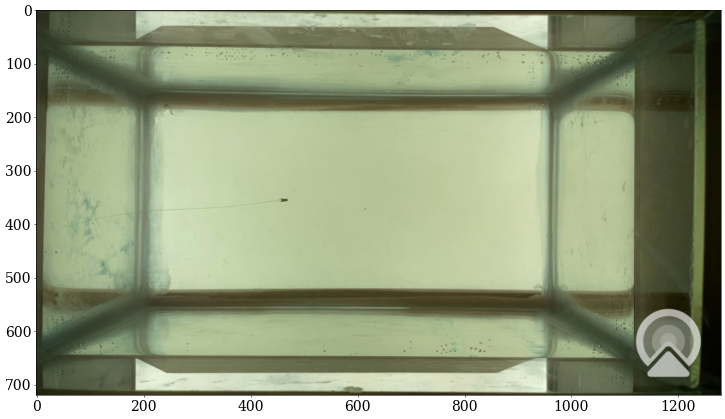

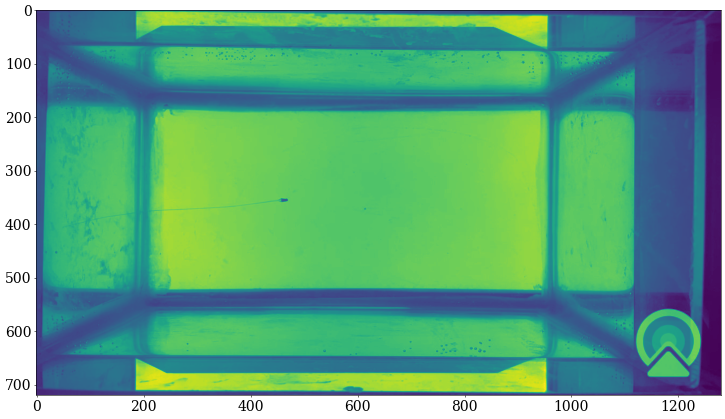

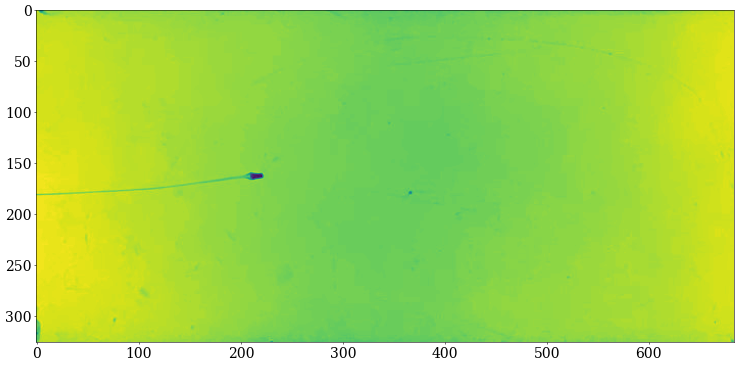

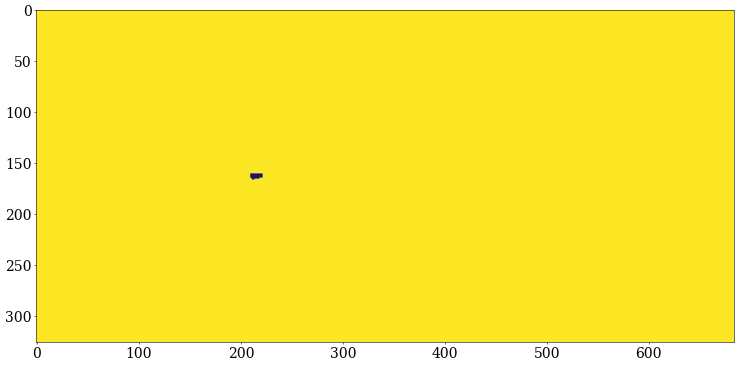

In [87]:
im = cv.imread('fotos\\Capturas\\Camo Snapshot 2024-05-17 - 10-34-47.jpg')
plt.figure()
plt.imshow(im)

# escala de grises
im_gray = gris(im)
plt.figure()
plt.imshow(im_gray)

# cortamos de modo que no se vea ningún borde (lo que asegura que lo más oscuro de la imagen sea la cabeza del nadador
# con un threshold adecuado podemos descartar la cola e inhomogeneidades del fondo.

im_cut = cortar(im_gray, limites=[248, 932, 193, 519])
plt.figure()
plt.imshow(im_cut)

# binarizamos
im_binary = binarize(im_cut)
plt.figure()
plt.imshow(im_binary)

#### Posición de la cabeza

In [88]:
# busco las coordenadas de los puntos que forman la cabeza
y, x = np.where(im_binary==0)

# elijo como coordenada para registrar la posición de la cabeza el punto de columna 'x' más a la derecha (porque en este
# caso nada hacia la derecha) y la fila 'y' más al medio (esto es igual a los videos finalmente analizados).
x_head = np.max(x)
filas_2 = np.unique(y)
y_head = int(np.mean(filas_2))

221

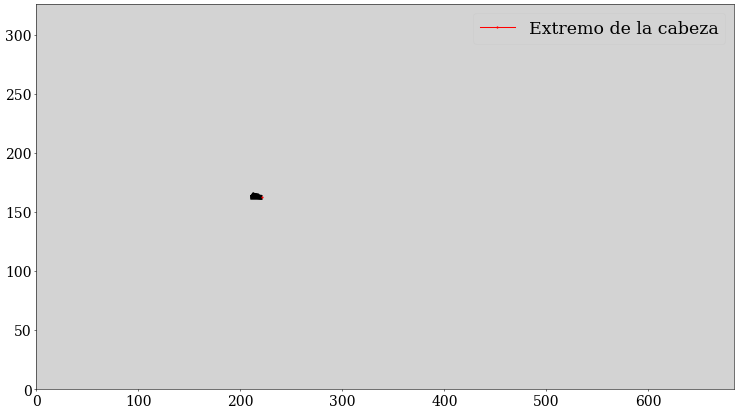

In [89]:
fig, ax = plt.subplots()
ax.set_xlim(0, len(im_binary[0]))
ax.set_ylim(0, len(im_binary))

ax.plot(x, y, color = 'k', marker='.', markersize=0.5)
ax.plot(x_head, y_head, color = 'r', marker='o', markersize=2, label='Extremo de la cabeza')
ax.legend()
x_head

### Ejemplo con un video (ECO20 45mm 2Vpp 3Hz)

In [90]:
# abro y analizo video
video = cv.VideoCapture('videos\\ECO20-45mm-PECERA1\\ECO20-45mm-2,04Vpp-3Hz.mp4')
lim = [319, 950, 250, 505] 
t,x,y = tracker(video, lim, SHOW=True)

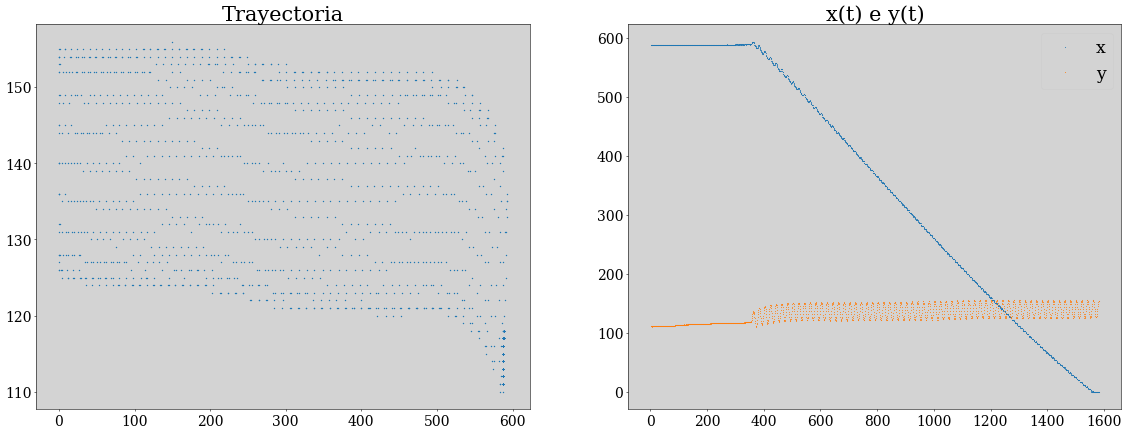

In [91]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (28, 10))
ax1.plot(x, y, 'o', markersize=1)
ax1.set_title('Trayectoria')

ax2.set_title('x(t) e y(t)')
ax2.plot(t[:len(x)], x, '.', markersize=1,label='x')
ax2.plot(t[:len(x)], y, '.', markersize=1, label='y')
ax2.legend()

### Maquina de hacer chorizos (sacar datos de posición de la cabeza para todos los videos)

In [7]:
import os

# en vez de 'videos' poner la carpeta donde estén todos los videos del nadador correspondiente
for filename in os.listdir('videos'):
    spl = filename.split('.')[0].split('-')
    v,f = spl[2],spl[3]
    video = cv.VideoCapture('videos/'+filename)
    lim = [319, 950, 250, 505] #[xleft, xright, ytop, ydown]
    t,x,y = tracker(video, lim, SHOW=False)

    # Guardo los datos (guardamos el tiempo recortado)
    pd.DataFrame().assign(t=t[:len(x)]).assign(x=x).assign(y=y).to_csv(f'ECO20-45mm/{v}-{f}.csv')
    
    # # Graficos de debuggeo
    # fig, [ax1, ax2] = plt.subplots(1, 2)

    # fig.suptitle(f'{v} ; {f}')
    
    # ax1.plot(x, y, '.')
    # ax2.plot(t[:len(x)], x, '.',label='x')
    # ax2.plot(t[:len(x)], y, '.', label='y')
    # ax2.legend()